## 농산물 가격 예측 AI 경진대회 가격 기준으로 클러스터링
### 0. 패키지 & 데이터 불러오기

!pip install tslearn

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

import collections
from tslearn.clustering import TimeSeriesKMeans

In [2]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
train = pd.read_csv('public_data/train.csv')
train.head()

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,...,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,...,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
4,2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,...,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0


### 01. 시계열 클러스터링
#### 1) 시계열 전처리

In [4]:
price = train.iloc[:, 3::2]
price.index = pd.to_datetime(train['date'])

#행에 대한 모델 적용 (행열 바꾸기)
price_t = price.transpose()
price_t.head()

date,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,...,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28
배추_가격(원/kg),0.0,329.0,0.0,478.0,442.0,442.0,448.0,420.0,389.0,0.0,...,1812.0,2925.0,1813.0,1838.0,1807.0,1839.0,1789.0,1760.0,3066.0,1867.0
무_가격(원/kg),0.0,360.0,0.0,382.0,422.0,409.0,428.0,390.0,345.0,0.0,...,919.0,760.0,872.0,916.0,955.0,990.0,1011.0,1075.0,1139.0,1147.0
양파_가격(원/kg),0.0,1281.0,0.0,1235.0,1213.0,1263.0,1241.0,1218.0,1210.0,0.0,...,976.0,1068.0,987.0,999.0,983.0,990.0,955.0,961.0,1056.0,964.0
건고추_가격(원/kg),0.0,11000.0,0.0,4464.0,4342.0,7041.0,3908.0,4836.0,5112.0,0.0,...,23563.0,0.0,13766.0,20227.0,23609.0,19101.0,23095.0,22510.0,22333.0,22022.0
마늘_가격(원/kg),0.0,5475.0,0.0,5210.0,5387.0,5013.0,4360.0,4850.0,4527.0,0.0,...,5003.0,0.0,5111.0,5496.0,5322.0,4775.0,5039.0,5565.0,5227.0,4757.0


#### 2) 시계열 클러스터링 모델링

In [70]:
def clustering_price(data,n_cluster):
    global labels
    
    #클러스터링 모델링
    ts = TimeSeriesKMeans(n_clusters=n_cluster, metric='dtw', max_iter=30, random_state= 2021)
    ts_pred= ts.fit_predict(data)
    print(ts_pred.shape)
    print(ts_pred)
    
    # collecter를 사용하여 변수 할당 & 분리
    import collections
    labels = []
    sizes = []
    for i in range(n_cluster):
        labels.append("cluster_"+str(i+1))
        sizes.append(collections.Counter(ts_pred)[i])
    print('클러스터 이름:', labels)
    print('클러스터링 개수:', sizes)
    
    #클러스터에 해당하는 변수 명 찾기 & 리스트 생성
    data_c = data.copy()
    data_c['labels'] = ts_pred
    cluster_list = []
    for i in range(0, n_cluster):
        reqd_Index = data_c[data_c['labels']== (i)].index.tolist()
        cluster_list.append(reqd_Index)
        
    return cluster_list

In [81]:
cluster_list = clustering_price(price_t,7)
cluster_list

(21,)
[5 5 5 2 4 5 5 5 6 3 1 5 4 1 1 1 3 1 1 4 0]
클러스터 이름: ['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7']
클러스터링 개수: [1, 6, 1, 2, 3, 7, 1]


[['샤인마스캇_가격(원/kg)'],
 ['미나리_가격(원/kg)',
  '새송이_가격(원/kg)',
  '팽이버섯_가격(원/kg)',
  '토마토_가격(원/kg)',
  '백다다기_가격(원/kg)',
  '애호박_가격(원/kg)'],
 ['건고추_가격(원/kg)'],
 ['시금치_가격(원/kg)', '청상추_가격(원/kg)'],
 ['마늘_가격(원/kg)', '파프리카_가격(원/kg)', '캠벨얼리_가격(원/kg)'],
 ['배추_가격(원/kg)',
  '무_가격(원/kg)',
  '양파_가격(원/kg)',
  '대파_가격(원/kg)',
  '얼갈이배추_가격(원/kg)',
  '양배추_가격(원/kg)',
  '당근_가격(원/kg)'],
 ['깻잎_가격(원/kg)']]

### 02. 클러스터링 한 농산물 데이터 분할
#### 1) 농산물 데이터 프레임 분할

In [82]:
def make_frame(data,n):
    listed = cluster_list[n]
    clustered_data = data[listed]
    return clustered_data

In [83]:
cluster_1 = make_frame(price,0)
cluster_2 = make_frame(price,1)
cluster_3 = make_frame(price,2)
cluster_4 = make_frame(price,3)
cluster_5 = make_frame(price,4)
cluster_6 = make_frame(price,5)
cluster_7 = make_frame(price,6)


cluster_8 = make_frame(price,7)
cluster_9 = make_frame(price,8)
cluster_10 = make_frame(price,9)

#### 2) 클러스터링 데이터 시각화

In [84]:
def clustered_EDA(data):
    data.plot(figsize=(15,10),kind='line')
    plt.title('cluster 시계열 그래프')
    plt.legend(fontsize=10,loc='upper left')
    plt.show()

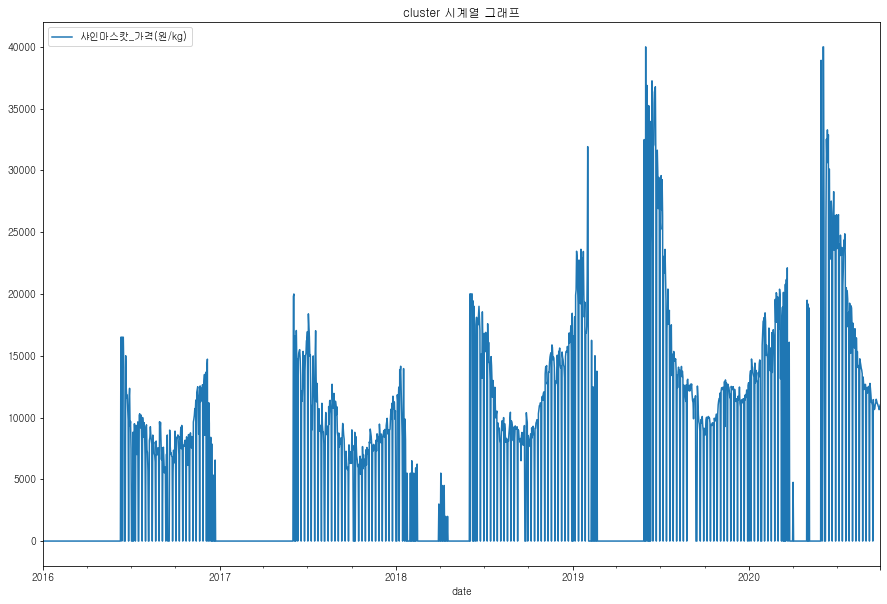

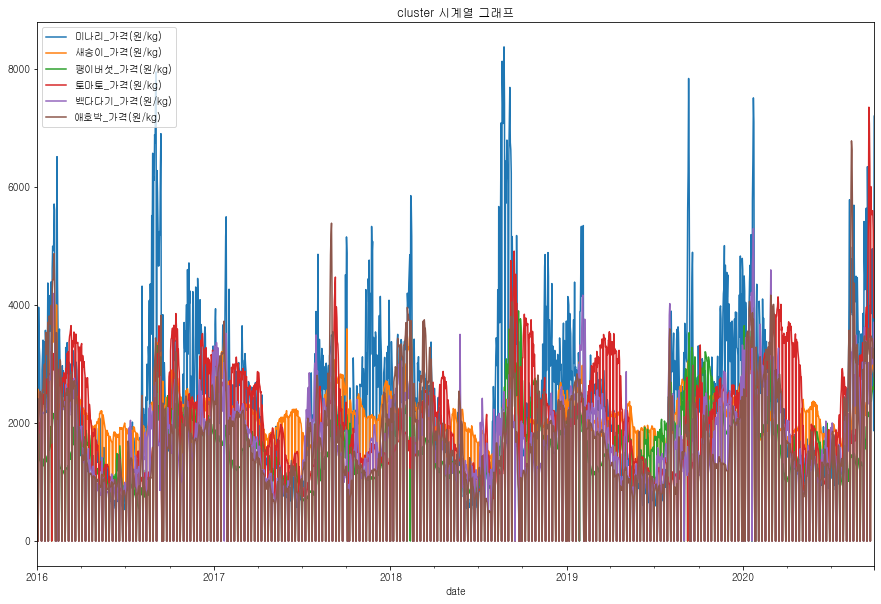

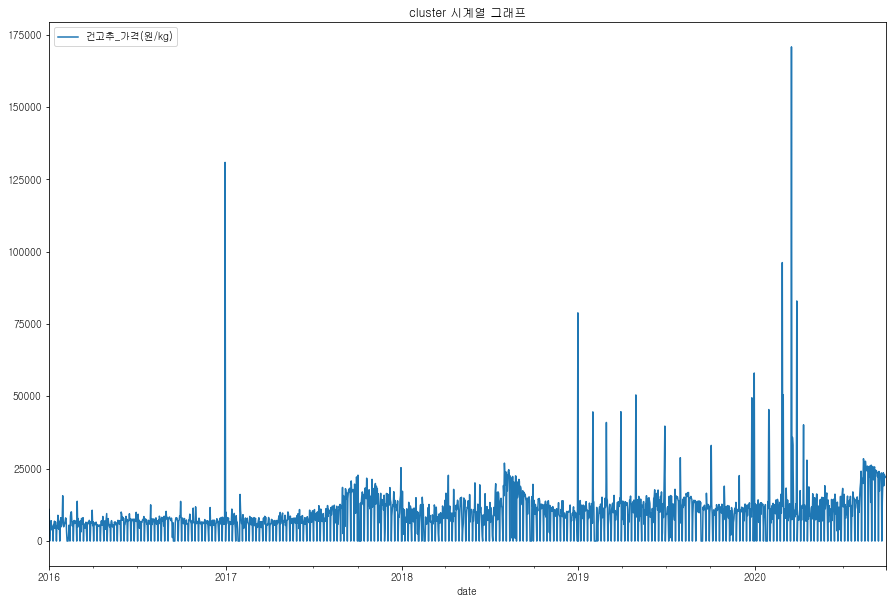

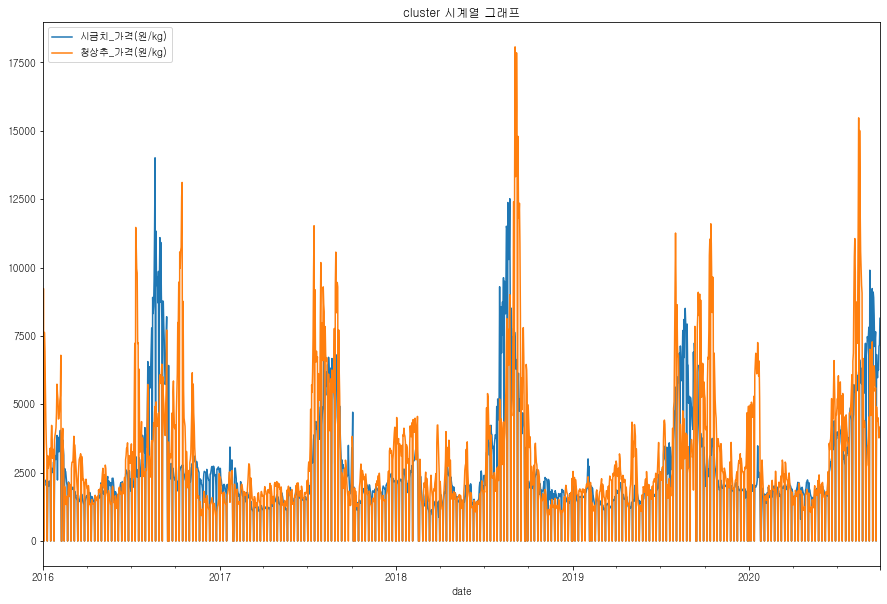

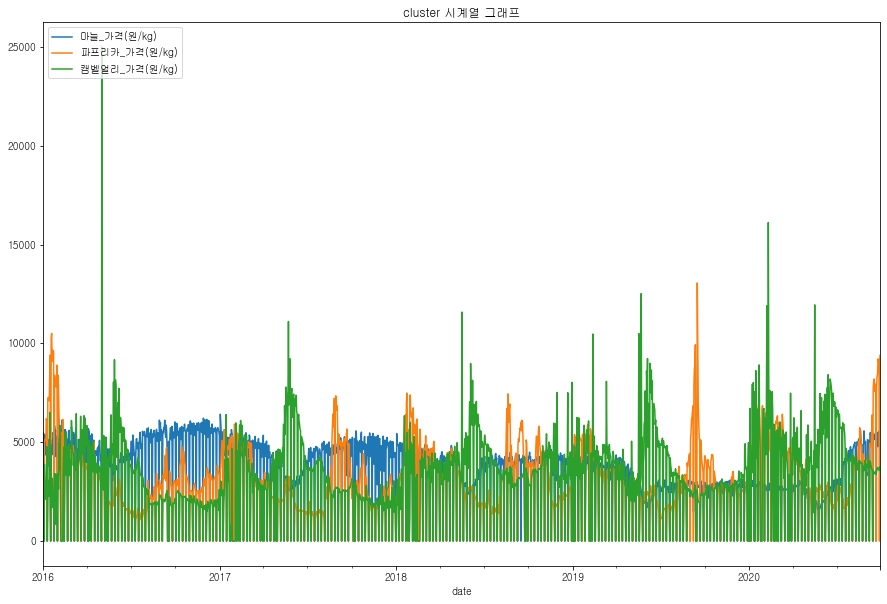

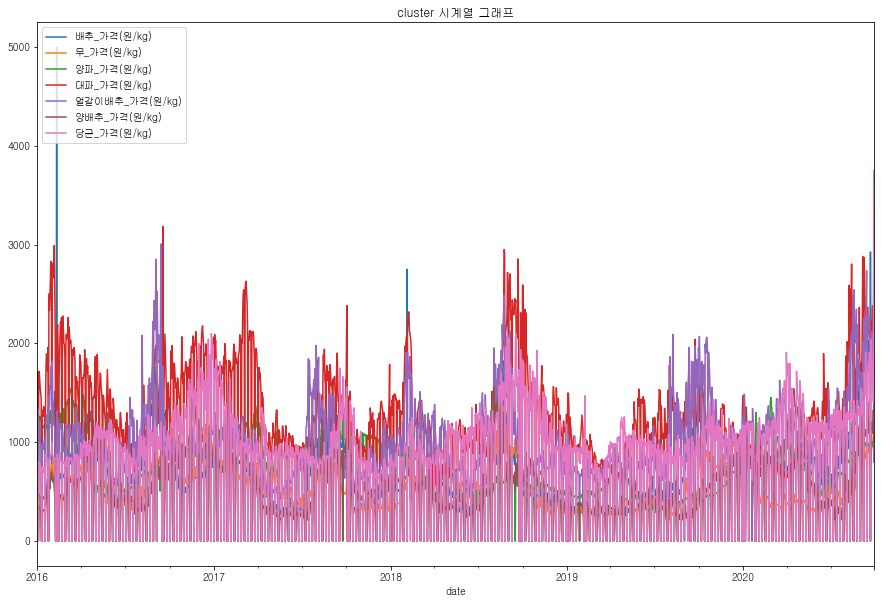

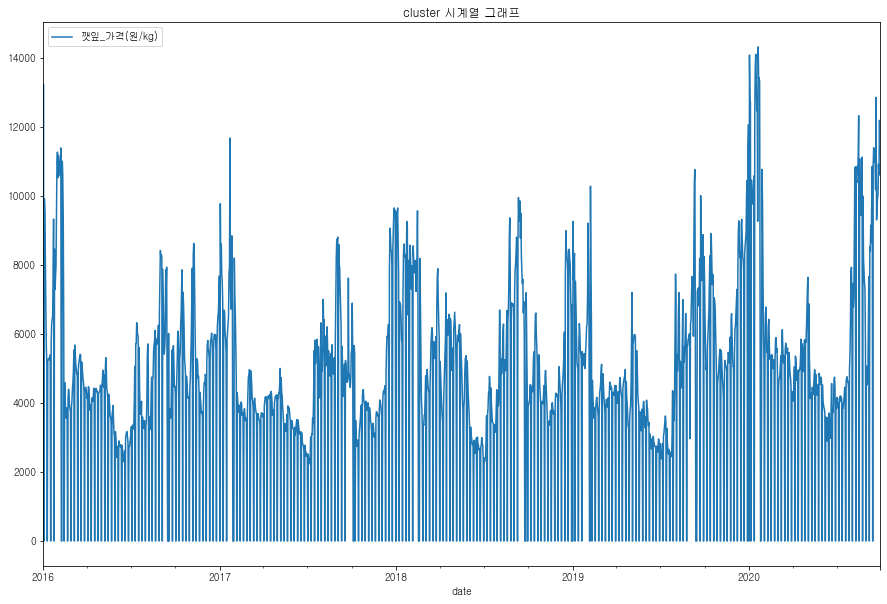

In [85]:
clustered_EDA(cluster_1)
clustered_EDA(cluster_2)
clustered_EDA(cluster_3)
clustered_EDA(cluster_4)
clustered_EDA(cluster_5)
clustered_EDA(cluster_6)
clustered_EDA(cluster_7)


clustered_EDA(cluster_8)
clustered_EDA(cluster_9)
clustered_EDA(cluster_10)

In [86]:
def clustered_ym_EDA(data):
    date = data.index.astype('str')
    data['year_month'] = date.str[:7]
    data_v1 = data.groupby(['year_month']).mean()
    data_v1.plot(figsize=(15,10),kind='line')
    plt.title('cluster 년월 평균 시계열 그래프')
    plt.legend(fontsize=10,loc='upper left')
    plt.show()

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


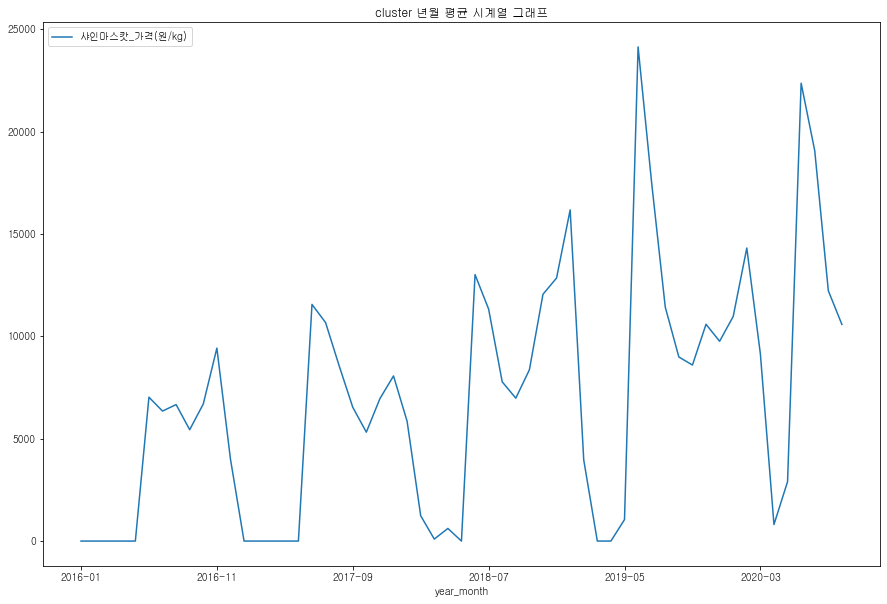

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


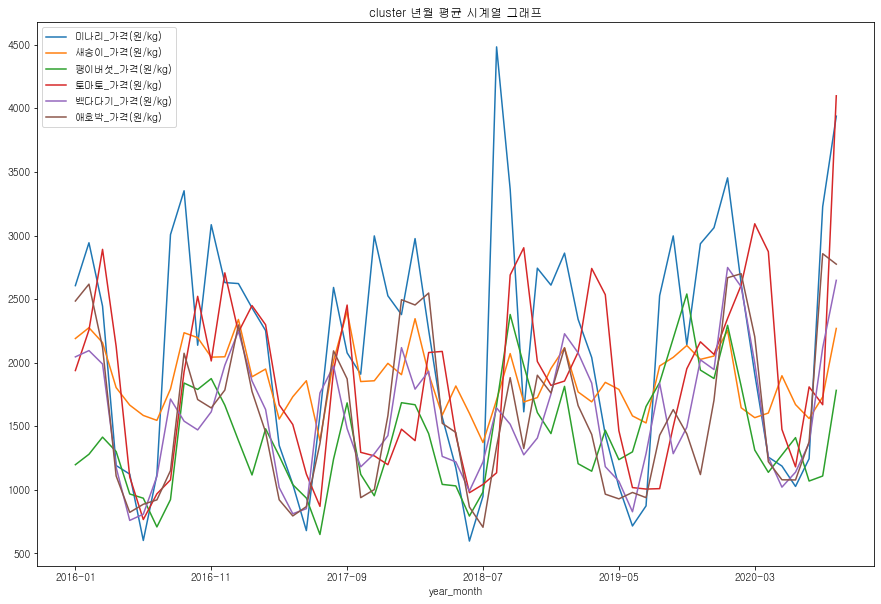

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


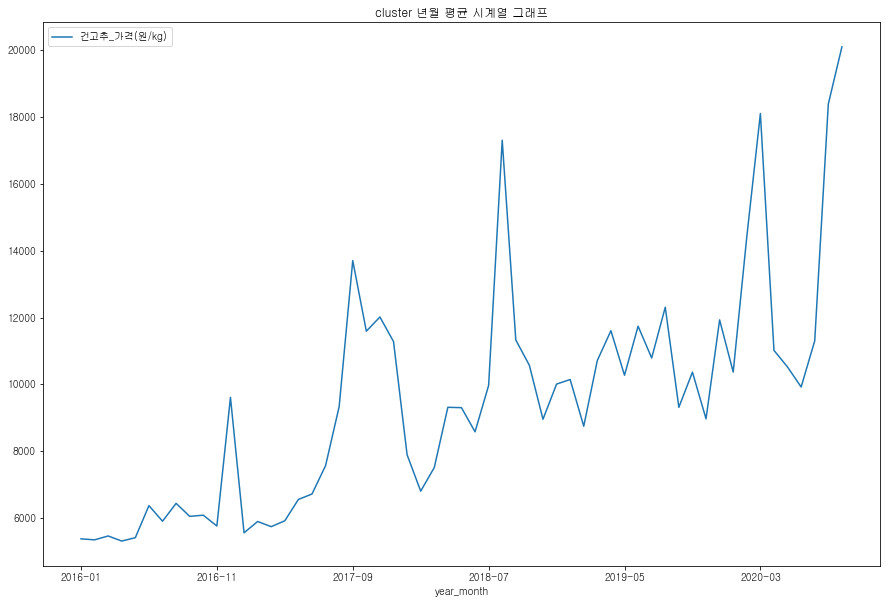

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


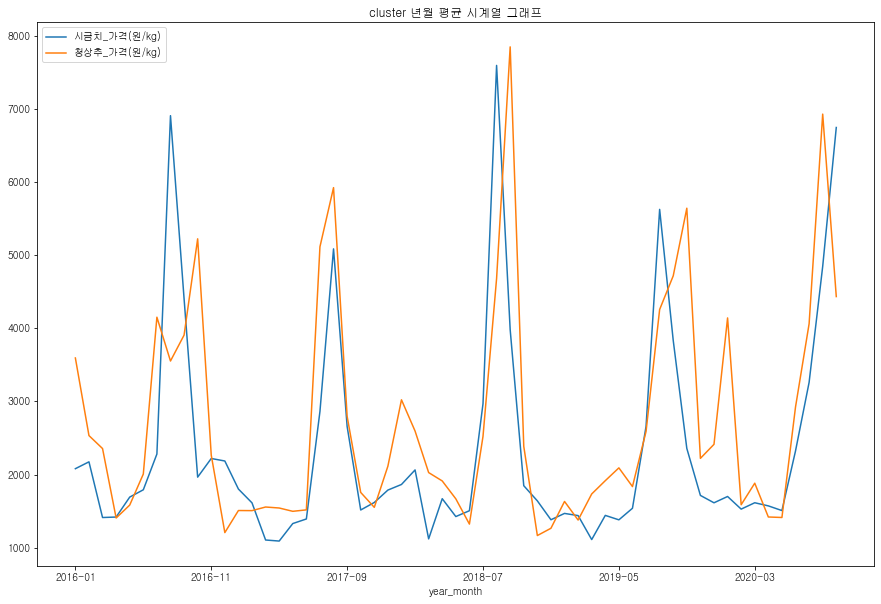

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


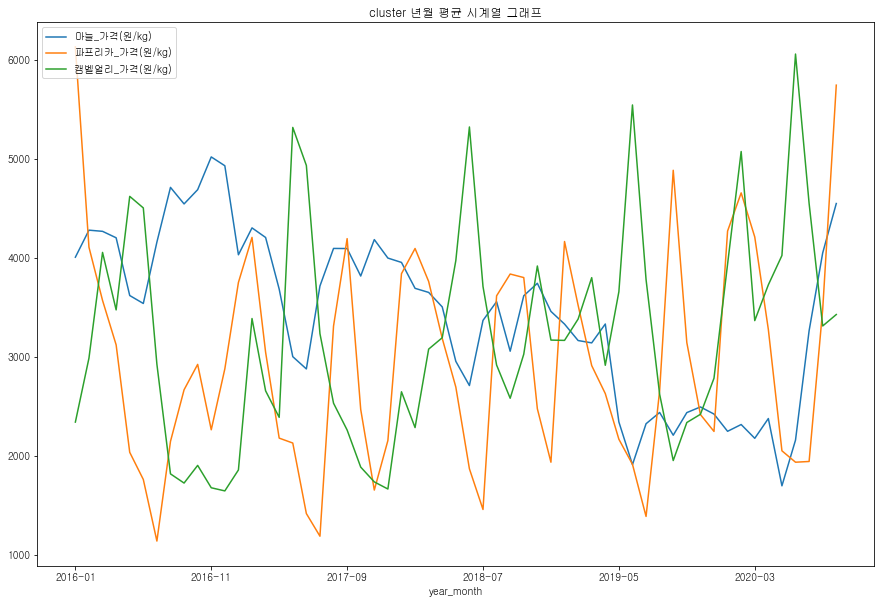

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


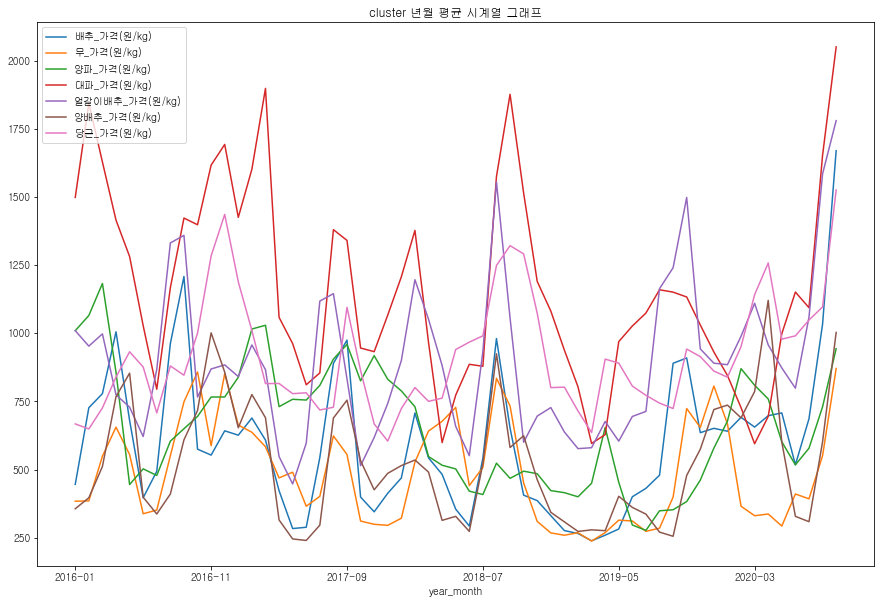

C:\Users\juyeo\AppData\Local\Temp/ipykernel_11360/4149541924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_month'] = date.str[:7]


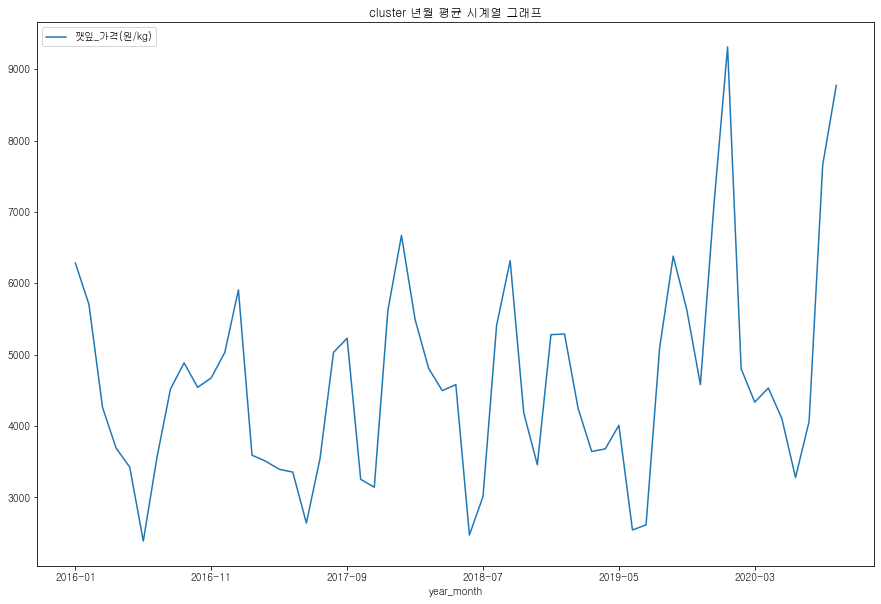

In [87]:
clustered_ym_EDA(cluster_1)
clustered_ym_EDA(cluster_2)
clustered_ym_EDA(cluster_3)
clustered_ym_EDA(cluster_4)
clustered_ym_EDA(cluster_5)
clustered_ym_EDA(cluster_6)
clustered_ym_EDA(cluster_7)
#clustered_ym_EDA(cluster_8)
#clustered_ym_EDA(cluster_9)
#clustered_ym_EDA(cluster_10)

In [11]:
cluster_list

[['샤인마스캇_가격(원/kg)'],
 ['미나리_가격(원/kg)',
  '새송이_가격(원/kg)',
  '팽이버섯_가격(원/kg)',
  '토마토_가격(원/kg)',
  '백다다기_가격(원/kg)',
  '애호박_가격(원/kg)'],
 ['건고추_가격(원/kg)'],
 ['시금치_가격(원/kg)', '청상추_가격(원/kg)'],
 ['마늘_가격(원/kg)', '파프리카_가격(원/kg)', '캠벨얼리_가격(원/kg)'],
 ['배추_가격(원/kg)',
  '무_가격(원/kg)',
  '양파_가격(원/kg)',
  '대파_가격(원/kg)',
  '얼갈이배추_가격(원/kg)',
  '양배추_가격(원/kg)',
  '당근_가격(원/kg)'],
 ['깻잎_가격(원/kg)']]

### 03. 클러스터링 된 데이터 저장?

cluster_1.to_csv('cluster_1.csv',index=False)
cluster_2.to_csv('cluster_2.csv',index=False)
cluster_3.to_csv('cluster_3.csv',index=False)
cluster_4.to_csv('cluster_4.csv',index=False)
cluster_5.to_csv('cluster_5.csv',index=False)
cluster_6.to_csv('cluster_6.csv',index=False)
cluster_7.to_csv('cluster_7.csv',index=False)

농산물 분류 O    
-> 가중치 계산 필요    
-> 무슨 가중치? (계절성, 수입여부, 수확시기 ...)    

RNN, LSTM,,, 